In [1]:
import pandas as pd

In [6]:
etude_num_2_str_dict  = {
    0 : "Aucune formation",
    1 : "4eme achevee",
    2 : "3eme achevee ou Brevet",
    3 : "CAP, BEP ou equivalent",
    4 : "Bac ou equivalent",
    5 : "Bac +2 ou equivalent",
    6 : "Bac +3 ou equivalent",
    7 : "Bac +4 ou equivalent",
    8 : "Bac +5 ou equivalent"
}

typeContrat_num_2_str_dict = {
    0 : 'CDI',
    1 : 'CDD',
    2 : 'MIS', 
    3 : 'DIN', 
    4 : 'CCE', 
    5 : 'LIB', 
    6 : 'FRA', 
    7 : 'SAI', 
    8 : 'REP', 
    9 : 'DDI', 
    10 : 'TTI'
}

tps_Pp_num_2_str_dict = {
    0 : "Temps partiel",
    1 : "Temps plein"
    }

qualification_num_2_str_dict = {
    8.0: "Agent de maîtrise",
    6.0: "Employé qualifié",
    9.0: "Cadre",
    5.0: "Employé non qualifié",
    2.0: "Ouvrier spécialisé",
    7.0: "Technicien",
    3.0: "Ouvrier qualifié (P1,P2)",
    1.0: "Manœuvre",
    4.0: "Ouvrier qualifié (P3,P4,OHQ)"
}


# analyse rapide des données

In [4]:
df = pd.read_csv(r"Romain_Scrapping\offres_emploi_concatene_cleaned.csv")

#df avec salaire
df_avec_salaire = df[df['salaire_annuel'].notnull()]

#df sans salaire
df_sans_salaire = df[df['salaire_annuel'].isnull()]

# XGboost

## Preparation des donneés

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost import XGBRegressor


In [67]:
# Colonnes
numerical_features = ['experience_requise', 'tps_Pp']
categorical_features = ['source', 'contrat', 'romeCode_extract', 'secteur_activite', 'qualificationCode', 'etude_requise','departement']

#Colonne a prédire
target = 'salaire_annuel'

X = df_avec_salaire.drop(columns=[target, 'intitule'])
y = df_avec_salaire[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
dtrain = xgb.DMatrix(data=X_train_transformed, label=y_train)

In [110]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 8,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1,
    "alpha": 0.1,
}
num_boost_round = 1000

bst = xgb.train(params, dtrain, num_boost_round)

In [111]:
from sklearn.metrics import root_mean_squared_error, r2_score

dtest = xgb.DMatrix(data=X_test_transformed, label=y_test)
# Predict on the test data
y_pred = bst.predict(dtest)
# Compute RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Compute R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r2}")


Root Mean Squared Error (RMSE): 7248.252812444887
R-squared (R2): 0.6761429100655048


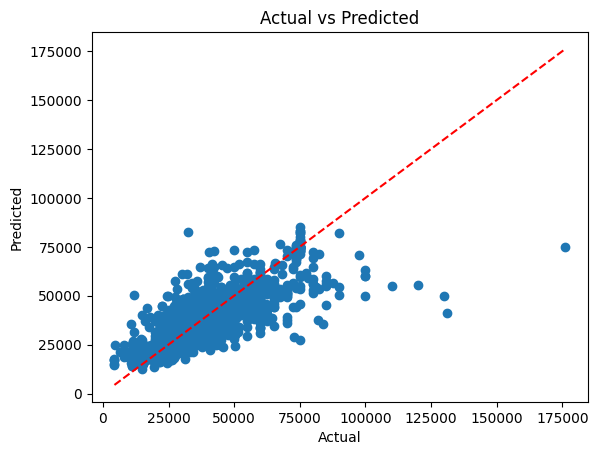

In [112]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


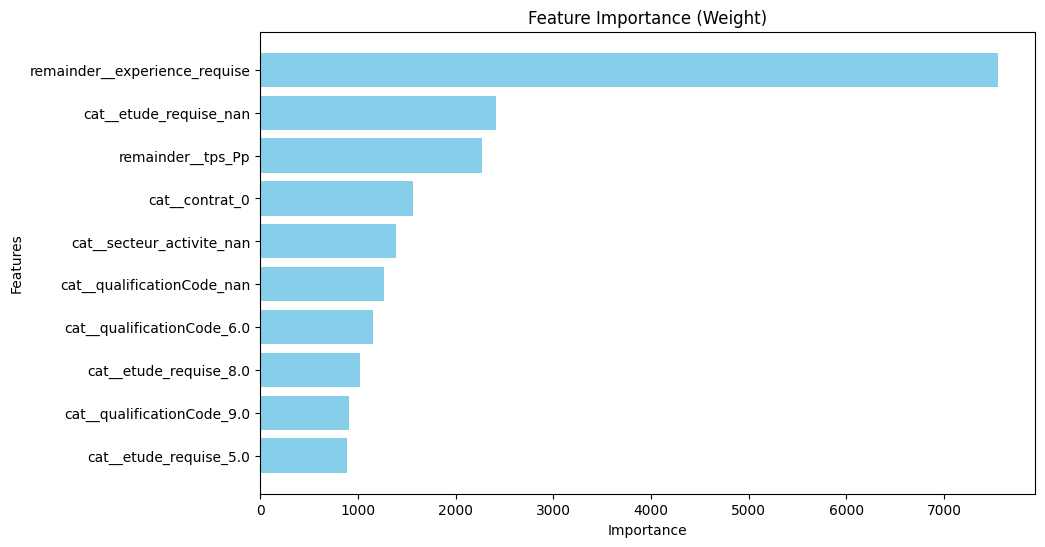

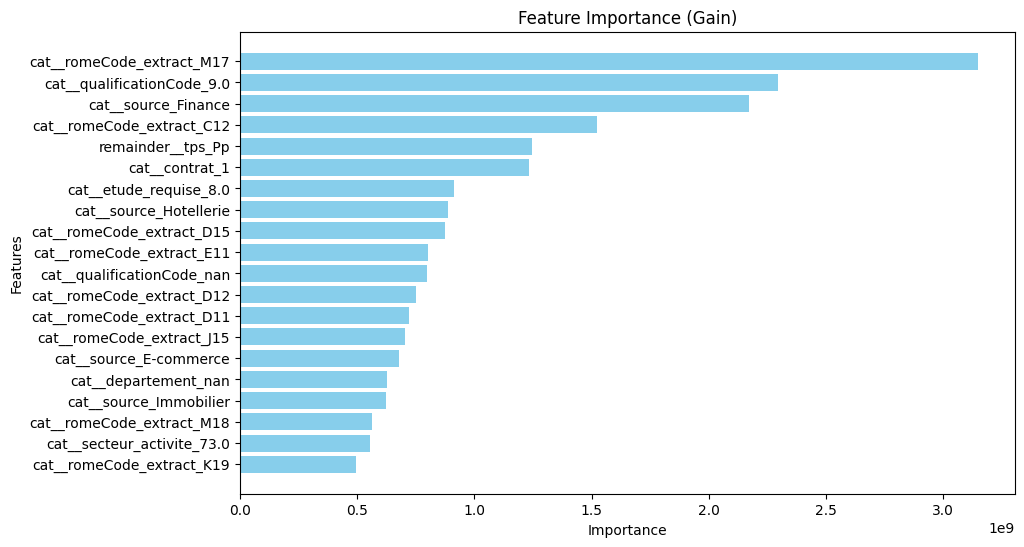

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import plot_importance

feature_names = preprocessor.get_feature_names_out()
# Fonction pour obtenir l'importance des caractéristiques avec des noms réels
def get_feature_importance_with_names(bst, feature_names, importance_type):
    feature_importances = bst.get_score(importance_type=importance_type)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': [feature_importances.get(f'f{i}', 0) for i in range(len(feature_names))]
    }).sort_values(by='Importance', ascending=False)
    return importance_df

# Obtenir les importances pour les trois types
importance_weight = get_feature_importance_with_names(bst, feature_names, importance_type='weight')
importance_gain = get_feature_importance_with_names(bst, feature_names, importance_type='gain')

# Visualiser les importances avec les noms réels des colonnes
def plot_feature_importance(importance_df, title, top_n=10):
    # Limiter aux top_n caractéristiques
    importance_df = importance_df.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()  # Inverser l'ordre pour correspondre au tri décroissant
    plt.show()

# Afficher les graphiques pour chaque type
plot_feature_importance(importance_weight, "Feature Importance (Weight)", top_n=10)
plot_feature_importance(importance_gain, "Feature Importance (Gain)", top_n=20)
